In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf

from kgl_wheat.utils import postprocess_bboxes, read_train_csv, get_train_val_split
from kgl_wheat import config
from kgl_wheat.dataset import get_dataset
from kgl_wheat.efficientdet.model import efficientdet

In [3]:
tf.random.set_seed(22)
np.random.seed(22)

image_paths, bboxes, image_sources = read_train_csv(
    train_csv_path=config.TRAIN_LABELS_FILE,
    train_images_dir=config.TRAIN_IMAGES_DIR
)

train_image_paths, train_bboxes, val_image_paths, val_bboxes = \
    get_train_val_split(
        image_paths=image_paths,
        image_bboxes=bboxes,
        image_sources=image_sources,
        seed=config.SEED,
        train_size=config.TRAIN_SIZE
    )

val_dataset = get_dataset(
    image_paths=val_image_paths,
    bboxes=None
)

model, prediction_model = efficientdet(
        num_classes=1,
        weighted_bifpn=True,
        freeze_bn=True,
        score_threshold=config.SCORE_THRESHOLD
    )

prediction_model.load_weights(config.MODEL_WEIGHTS_PATH, by_name=True)

pred_bboxes, pred_scores, pred_labels = prediction_model.predict(val_dataset, verbose=1)

264/264 [==============================] - 105s 396ms/step


In [4]:
pred_bboxes, pred_scores, pred_labels = np.squeeze(pred_bboxes), np.squeeze(pred_scores), np.squeeze(pred_labels)

pred_bboxes = postprocess_bboxes(bboxes=pred_bboxes, height=config.IMAGE_SIZE, width=config.IMAGE_SIZE)

In [5]:
pred_bboxes_filtered = []
pred_scores_filtered = []
for image_pred_bboxes, image_pred_scores in zip(pred_bboxes, pred_scores):
    indices = image_pred_scores > config.SCORE_THRESHOLD
    pred_bboxes_filtered.append(image_pred_bboxes[indices])
    pred_scores_filtered.append(image_pred_scores[indices])

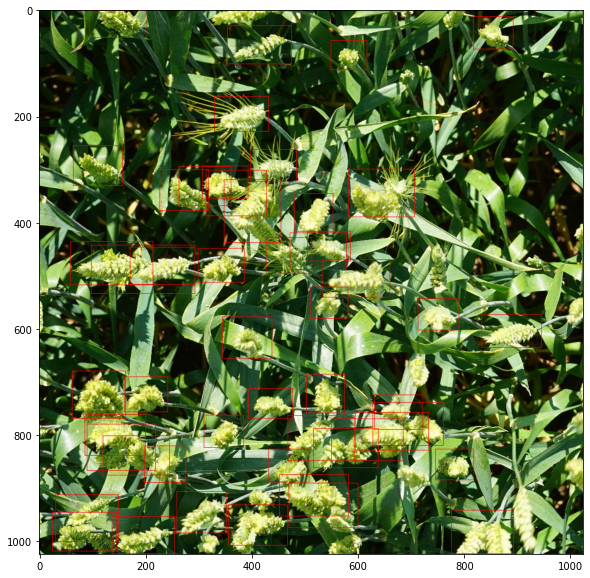

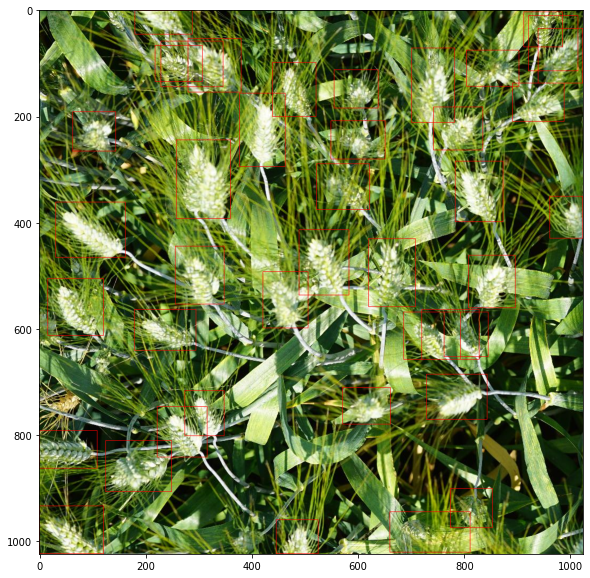

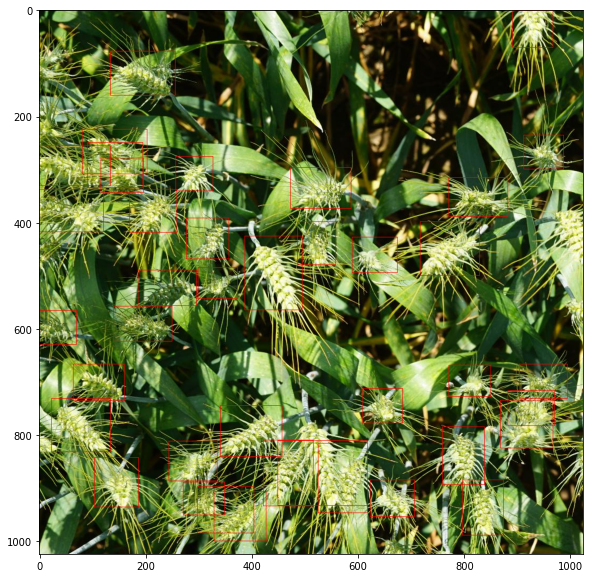

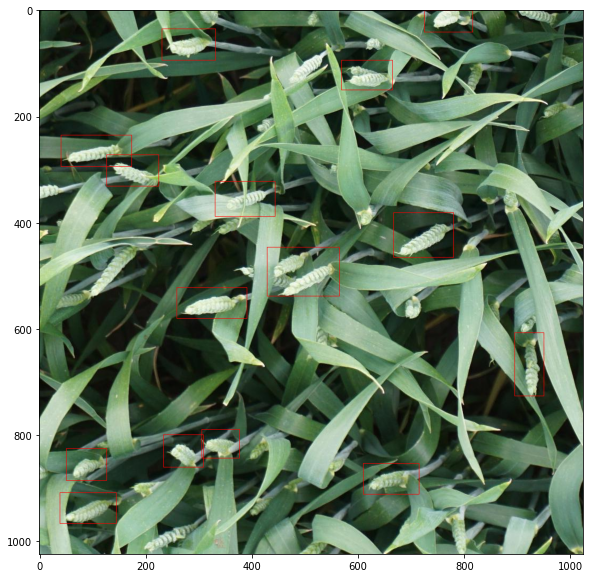

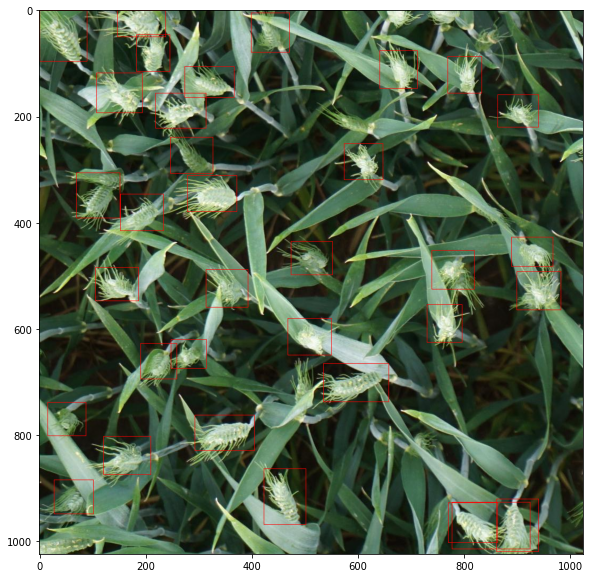

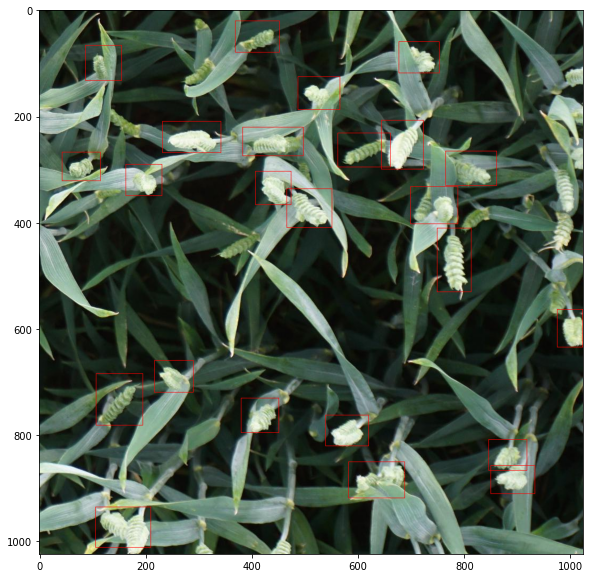

In [ ]:
# uncomment to plot detections
for image_bboxes, image_path in list(zip(pred_bboxes_filtered, val_image_paths))[:10]:
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    for bbox in image_bboxes:
        cv2.rectangle(
            image,
            (bbox[0], bbox[1]),
            (bbox[0]+bbox[2], bbox[1]+bbox[3]),
            (255,0,0)
        )
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    plt.show()